In [1]:
import numpy as np
from scipy.linalg import *
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame,Series
import math
import time

In [102]:
k = 52 #W/m°C - Aço 1020
L = 10 #m - Comprimento
t = 0.006 #m - Espessura
h = 400 #W/m²°C Convecção Forçada
T0 = 400 #°C
T_infinito = 25 #°C
w = 1 #m - Largura
u = 1 #m/s
rho = 7800 #kg/m³
cp = 486 #j/kgK

In [103]:
meshx = 120
deltax = L/(meshx-0.5)

meshy = 120
deltay = (t/2)/(meshy-1)

Pe = rho*u*deltax/(k/cp)
deltax_max = 2 *(k/cp)/(rho*u)

In [104]:
Pe

6100.418410041841

In [105]:
x_plot = np.zeros(meshx)
y_plot = np.zeros(meshy)
T_exato = np.zeros(meshx)


x_plot[0] = deltax/2
for x in range(1,meshx):
    x_plot[x] = x_plot[x-1] + deltax
    
y_plot[0] = 0
for y in range(1,meshy):
    y_plot[y] = y_plot[y-1] + deltay
    

In [106]:
#Numérico 2D - CDS
M = rho*u*deltay*w

tempo_inicial = time.time()
Matrix_coef_a = np.zeros((meshx*meshy,meshx*meshy))
Matrix_coef_b = np.zeros((meshx*meshy,1))
T=np.zeros((meshx*meshy,1))
ae = np.zeros((meshx,meshy))
aw = np.zeros((meshx,meshy))
an = np.zeros((meshx,meshy))
aS = np.zeros((meshx,meshy))
ap = np.zeros((meshx,meshy))
b = np.zeros((meshx,meshy))
 
for x in range(meshx):
    for y in range(meshy):
        #volume inferior esquerdo
        if (x == 0) and (y==0):
            aw[x,y] = 0
            ae[x,y] = (k*(deltay/2)*w/deltax)/cp -M/4
            an[x,y] = (k*deltax*w/deltay)/cp
            aS[x,y] = 0
            aw_f = (k*(deltay/2)*w/(deltax/2))/cp
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f + M/2
            b[x,y] = (aw_f+M/2)*T0
            
        #volume inferior direito
        if (x == 0) and (y==meshy-1):
            aw[x,y] = (k*(deltay/2)*w/deltax)/cp + M/4
            ae[x,y] = 0
            an[x,y] = (k*(deltax/2)*w/deltay)/cp
            aS[x,y] = 0            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
        
        #volume superior esquerdo
        if (x == meshx-1) and (y==0):
            aw[x,y] = 0
            ae[x,y] = (k*(deltay/2)*w/deltax)/cp -M/4
            an[x,y] = 0
            aS[x,y] = (k*deltax*w/deltay)/cp
            an_f = (h*deltax*w)/cp
            aw_f = (k*(deltay/2)*w/(deltax/2))/cp
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f + an_f +M/2
            b[x,y] = (aw_f+M/2)*T0 + an_f*T_infinito
            
        #volume superior direito
        if (x == meshx-1) and (y==meshy-1):
            aw[x,y] = (k*(deltay/2)*w/deltax)/cp+M/4
            ae[x,y] = 0
            an[x,y] = 0
            aS[x,y] = (k*(deltax/2)*w/(deltay))/cp 
            an_f = (h*(deltax/2)*w)/cp
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +an_f
            b[x,y] = an_f*T_infinito
            
        #volumes na face esquerda
        if (y == 0) and (x>0) and (x<meshx-1):
            aw[x,y] = 0
            ae[x,y] = (k*deltay*w/deltax)/cp - M/2
            an[x,y] = (k*deltax*w/deltay)/cp
            aS[x,y] = (k*deltax*w/deltay)/cp
            aw_f = (k*deltay*w/(deltax/2))/cp
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f+M
            b[x,y] = (aw_f+M)*T0
            
        #volumes na face direita
        if (y == meshy-1) and (x>0) and (x<meshx-1):
            aw[x,y] = (k*deltay*w/deltax)/cp +M/2
            ae[x,y] = 0
            an[x,y] = (k*(deltax/2)*w/deltay)/cp
            aS[x,y] = (k*(deltax/2)*w/deltay )/cp           
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0  
            
        #volumes no norte
        if (x == meshx-1) and (y>0) and (y<meshy-1):
            aw[x,y] = (k*(deltay/2)*w/deltax)/cp + M/4
            ae[x,y] = (k*(deltay/2)*w/deltax)/cp - M/4
            an[x,y] = 0
            aS[x,y] = (k*deltax*w/deltay )/cp
            an_f = (h*deltax*w)/cp
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +an_f
            b[x,y] = an_f*T_infinito
            
        #volumes no sul
        if (x == 0) and (y>0) and (y<meshy-1):
            aw[x,y] = (k*(deltay/2)*w/deltax)/cp +M/4
            ae[x,y] = (k*(deltay/2)*w/deltax)/cp - M/4
            an[x,y] = (k*deltax*w/deltay)/cp
            aS[x,y] = 0            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
            
        #volumes internos
        if (x>0) and (x < meshx-1) and (y>0) and (y<meshy-1):
            aw[x,y] = (k*deltay*w/deltax)/cp + M/2
            ae[x,y] = (k*deltay*w/deltax)/cp - M/2
            an[x,y] = (k*deltax*w/deltay)/cp
            aS[x,y] = an[x,y]            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
        
                     
#montando a matriz de coeficientes:
cont = 0
for x in range(meshx):
    for y in range(meshy):
        Matrix_coef_a[cont,cont] = ap[x,y]
        Matrix_coef_a[cont,cont-1] = -aw[x,y]
        
        if cont < meshx*meshy-1:
            Matrix_coef_a[cont,cont+1] = -ae[x,y]
        if cont < meshx*meshy-meshy:   
            Matrix_coef_a[cont,cont+meshy] = -an[x,y]
        if cont >meshy-1:
            Matrix_coef_a[cont,cont-meshy] = -aS[x,y]
        
        
        Matrix_coef_b[cont,0] = b[x,y]
        cont += 1
        
    
T = solve(Matrix_coef_a,Matrix_coef_b)

TCDS = np.zeros((meshx,meshy))


#transformando o vetor Temperatura em Matriz

cont = 0
for x in range(meshx):
    for y in range(meshy):
        TCDS[x,y] = T[cont]
        cont += 1
        
T_medCDS = np.zeros(meshx)
for x in range (meshx):
    T_medCDS[x] = sum(TCDS[:,x])/meshy 
    


q_condCDS =np.zeros(meshx)
q_advCDS = np.zeros(meshx)

q_condCDS[0] = (T0 - TCDS[0,0]) * k *(deltay/2)*w/(deltax/2)
q_advCDS[0] = (T0 - TCDS[0,meshy-1]) * cp * rho * (deltay/2)*w*u
for x in range(1,meshx-1):
    q_condCDS[x] = (T0 - TCDS[x,0]) * k *deltay*w/(deltax/2)
    q_advCDS[x] = (T0 - TCDS[x,meshy-1]) * cp * rho * deltay*w*u
q_condCDS[meshx-1] = (T0 - TCDS[meshx-1,0]) * k *(deltay/2)*w/(deltax/2)
q_advCDS[meshx-1] = (T0 - TCDS[meshx-1,meshy-1]) * cp * rho * (deltay/2)*w*u

q_convCDS = np.zeros(meshy)
for y in range(meshy-1):
    q_convCDS[y] = (TCDS[meshx-1,y] - T_infinito) * h * deltax*w
q_convCDS[meshy-1] = (TCDS[meshx-1,meshy-1] - T_infinito) * h * (deltax/2)*w

q_cond_totalCDS = sum(q_condCDS) *2
q_conv_totalCDS = sum(q_convCDS) *2
q_adv_totalCDS = sum (q_advCDS) *2

tempo_final = time.time()

tempo = tempo_final-tempo_inicial


In [107]:
#Numérico 2D - UDS
M = rho*u*deltay*w

tempo_inicial = time.time()
Matrix_coef_a = np.zeros((meshx*meshy,meshx*meshy))
Matrix_coef_b = np.zeros((meshx*meshy,1))
T=np.zeros((meshx*meshy,1))
ae = np.zeros((meshx,meshy))
aw = np.zeros((meshx,meshy))
an = np.zeros((meshx,meshy))
aS = np.zeros((meshx,meshy))
ap = np.zeros((meshx,meshy))
b = np.zeros((meshx,meshy))
 
for x in range(meshx):
    for y in range(meshy):
        #volume inferior esquerdo
        if (x == 0) and (y==0):
            aw[x,y] = 0
            ae[x,y] = (k*(deltay/2)*w/deltax)/cp 
            an[x,y] = (k*deltax*w/deltay)/cp
            aS[x,y] = 0
            aw_f = (k*(deltay/2)*w/(deltax/2))/cp
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f + M/2
            b[x,y] = (aw_f+M/2)*T0
            
        #volume inferior direito
        if (x == 0) and (y==meshy-1):
            aw[x,y] = (k*(deltay/2)*w/deltax)/cp + M/2
            ae[x,y] = 0
            an[x,y] = (k*(deltax/2)*w/deltay)/cp
            aS[x,y] = 0            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
        
        #volume superior esquerdo
        if (x == meshx-1) and (y==0):
            aw[x,y] = 0
            ae[x,y] = (k*(deltay/2)*w/deltax)/cp 
            an[x,y] = 0
            aS[x,y] = (k*deltax*w/deltay)/cp
            an_f = (h*deltax*w)/cp
            aw_f = (k*(deltay/2)*w/(deltax/2))/cp
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f + an_f +M/2
            b[x,y] = (aw_f+M/2)*T0 + an_f*T_infinito
            
        #volume superior direito
        if (x == meshx-1) and (y==meshy-1):
            aw[x,y] = (k*(deltay/2)*w/deltax)/cp+M/2
            ae[x,y] = 0
            an[x,y] = 0
            aS[x,y] = (k*(deltax/2)*w/(deltay))/cp 
            an_f = (h*(deltax/2)*w)/cp
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +an_f
            b[x,y] = an_f*T_infinito
            
        #volumes na face esquerda
        if (y == 0) and (x>0) and (x<meshx-1):
            aw[x,y] = 0
            ae[x,y] = (k*deltay*w/deltax)/cp 
            an[x,y] = (k*deltax*w/deltay)/cp
            aS[x,y] = (k*deltax*w/deltay)/cp
            aw_f = (k*deltay*w/(deltax/2))/cp
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +aw_f+M
            b[x,y] = (aw_f+M)*T0
            
        #volumes na face direita
        if (y == meshy-1) and (x>0) and (x<meshx-1):
            aw[x,y] = (k*deltay*w/deltax)/cp +M
            ae[x,y] = 0
            an[x,y] = (k*(deltax/2)*w/deltay)/cp
            aS[x,y] = (k*(deltax/2)*w/deltay )/cp           
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0  
            
        #volumes no norte
        if (x == meshx-1) and (y>0) and (y<meshy-1):
            aw[x,y] = (k*(deltay/2)*w/deltax)/cp + M/2
            ae[x,y] = (k*(deltay/2)*w/deltax)/cp 
            an[x,y] = 0
            aS[x,y] = (k*deltax*w/deltay )/cp
            an_f = (h*deltax*w)/cp
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] +an_f
            b[x,y] = an_f*T_infinito
            
        #volumes no sul
        if (x == 0) and (y>0) and (y<meshy-1):
            aw[x,y] = (k*(deltay/2)*w/deltax)/cp +M/2
            ae[x,y] = (k*(deltay/2)*w/deltax)/cp 
            an[x,y] = (k*deltax*w/deltay)/cp
            aS[x,y] = 0            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
            
        #volumes internos
        if (x>0) and (x < meshx-1) and (y>0) and (y<meshy-1):
            aw[x,y] = (k*deltay*w/deltax)/cp+M
            ae[x,y] = aw[x,y] - M
            an[x,y] = (k*deltax*w/deltay)/cp
            aS[x,y] = an[x,y]            
            ap[x,y] = aw[x,y] + ae[x,y] + an[x,y] + aS[x,y] 
            b[x,y] = 0
        
                     
#montando a matriz de coeficientes:
cont = 0
for x in range(meshx):
    for y in range(meshy):
        Matrix_coef_a[cont,cont] = ap[x,y]
        Matrix_coef_a[cont,cont-1] = -aw[x,y]
        
        if cont < meshx*meshy-1:
            Matrix_coef_a[cont,cont+1] = -ae[x,y]
        if cont < meshx*meshy-meshy:   
            Matrix_coef_a[cont,cont+meshy] = -an[x,y]
        if cont >meshy-1:
            Matrix_coef_a[cont,cont-meshy] = -aS[x,y]
        
        
        Matrix_coef_b[cont,0] = b[x,y]
        cont += 1
        
    
T = solve(Matrix_coef_a,Matrix_coef_b)

TUDS = np.zeros((meshx,meshy))


#transformando o vetor Temperatura em Matriz

cont = 0
for x in range(meshx):
    for y in range(meshy):
        TUDS[x,y] = T[cont]
        cont += 1

T_medUDS = np.zeros(meshx)
for x in range (meshx):
    T_medUDS[x] = sum(TUDS[:,x])/meshy 
    
    
q_condUDS =np.zeros(meshx)
q_advUDS = np.zeros(meshx)
q_condUDS[0] = (T0 - TUDS[0,0]) * k *(deltay/2)*w/(deltax/2)
q_advUDS[0] = (T0 - TUDS[0,meshy-1]) * cp * rho * (deltay/2)*w *u
for x in range(1,meshx-1):
    q_condUDS[x] = (T0 - TUDS[x,0]) * k *deltay*w/(deltax/2)
    q_advUDS[x] = (T0 - TUDS[x,meshy-1]) * cp * rho * deltay*w*u
q_condUDS[meshx-1] = (T0 - TUDS[meshx-1,0]) * k *(deltay/2)*w/(deltax/2)
q_advUDS[meshx-1] = (T0 - TUDS[meshx-1,meshy-1]) * cp * rho * (deltay/2)*w*u

q_convUDS = np.zeros(meshy)
for y in range(meshy-1):
    q_convUDS[y] = (TUDS[meshx-1,y] - T_infinito) * h * deltax*w
q_convUDS[meshy-1] = (TUDS[meshx-1,meshy-1] - T_infinito) * h * (deltax/2)*w

q_cond_totalUDS = sum(q_condUDS) *2
q_conv_totalUDS = sum(q_convUDS) *2
q_adv_totalUDS = sum(q_advUDS) *2

tempo_final = time.time()

tempo = tempo_final-tempo_inicial

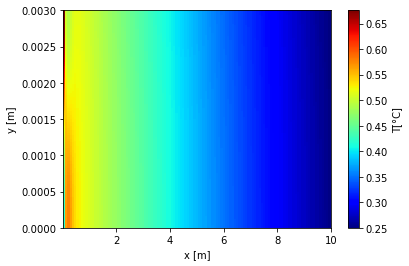

In [108]:
#Grafico 2D
%matplotlib inline
        
X,Y = np.meshgrid(x_plot,y_plot)

fig, ax = plt.subplots()

#ax.contourf(X,Y,T_plot,)
p = ax.pcolor(X, Y, TCDS, cmap='jet', vmin=abs(TCDS).min(), vmax=abs(TCDS).max())
#p = ax.pcolor(X, Y, abs(TUDS-TCDS), cmap='jet')
cb = fig.colorbar(p, ax=ax)

cb.set_label('T[°C]')

ax.set_ylabel('y [m]')
ax.set_xlabel('x [m]')
#ax.set_title('UDS')





In [36]:
#T_medCDS_plot.append(T_medCDS)
#T_medUDS_plot.append(T_medUDS)

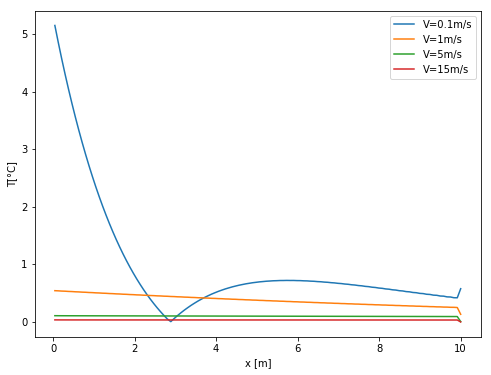

In [99]:
#Grafico 1D
%matplotlib inline

fig = plt.figure(figsize=(8,6))
axis = fig.add_subplot(111)

vel = [0.1,1,5,15]          
for i in range(4):
    #axis.plot(x_plot,T_medCDS_plot[i],label='CDS',color = colors[i])
    #axis.plot(x_plot,T_medUDS_plot[i],label='UDS',ls='--',color = colors[i])
    axis.plot(x_plot,abs(T_medCDS_plot[i]-T_medUDS_plot[i]),label='V=' +str(vel[i])+'m/s')
    #axis.plot(x_plot,(T_medCDS-T_medUDS),label='V=' +str(vel[i])+'m/s')
    
axis.set_ylabel('T[°C]')
axis.set_xlabel('x [m]')
axis.set_title('')
axis.legend(loc='best')